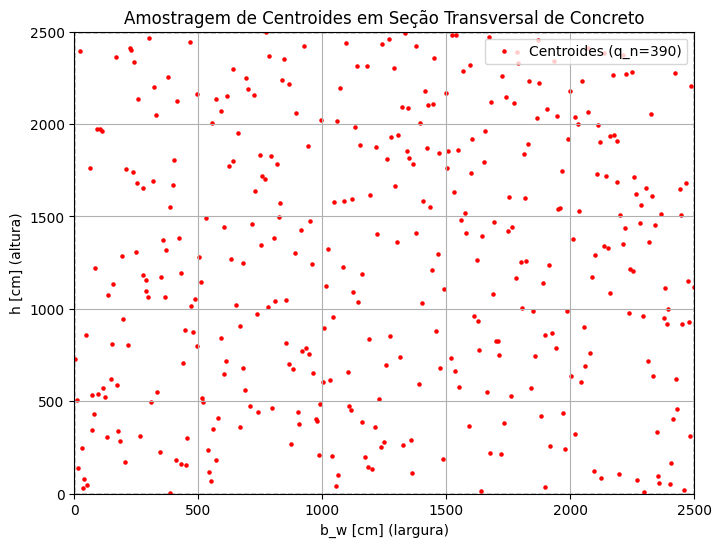

In [1]:
import matplotlib.pyplot as plt
from scipy.stats import qmc

# === Parâmetros de entrada ===
q_n = 390            # Quantidade de pontos (centroides)
b_w_max = 2500       # Largura máxima da seção em cm (eixo x)
h_max = 2500         # Altura máxima da seção em cm (eixo y)

# === Geração dos pontos via Amostragem por Hipercubo Latino ===
sampler = qmc.LatinHypercube(d=2)
sample = sampler.random(n=q_n)

# Escalando os pontos para o domínio da seção de concreto
scaled_sample = qmc.scale(sample, l_bounds=[0, 0], u_bounds=[b_w_max, h_max])

# Separando coordenadas x (largura) e y (altura)
x_centroids = scaled_sample[:, 0]
y_centroids = scaled_sample[:, 1]

# === Plotagem ===
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Amostragem de Centroides em Seção Transversal de Concreto')
ax.set_xlabel('b_w [cm] (largura)')
ax.set_ylabel('h [cm] (altura)')
ax.set_xlim(0, b_w_max)
ax.set_ylim(0, h_max)

# Retângulo da seção
ax.add_patch(plt.Rectangle((0, 0), b_w_max, h_max, fill=False, edgecolor='black', linestyle='--'))

# Plotando os pontos em vermelho
ax.scatter(x_centroids, y_centroids, color='red', s=5, label=f'Centroides (q_n={q_n})')
ax.legend(loc="upper right")

plt.grid(True)
plt.show()

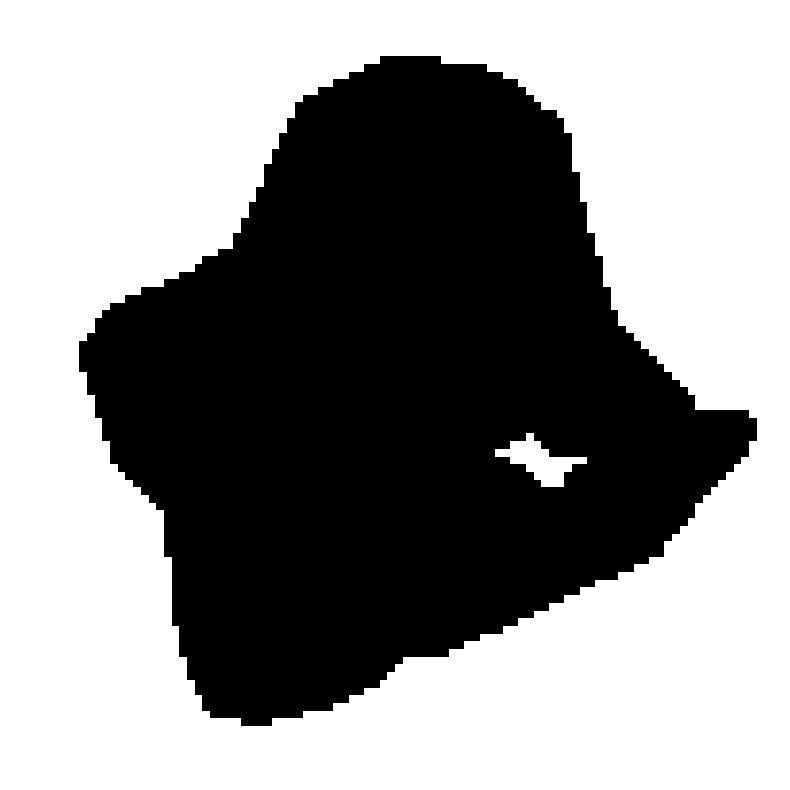

Pixels iniciais: 10000
Figura 2 (03_574.png): área = 3501, sobreposição = 0 pixels, disponíveis = 6499,  0
Figura 3 (15_48.png): área = 1318, sobreposição = 468 pixels, disponíveis = 5649,  1
Figura 4 (05_371.png): área = 764, sobreposição = 595 pixels, disponíveis = 5480,  1
Figura 5 (14_78.png): área = 749, sobreposição = 744 pixels, disponíveis = 5475,  1


(array([[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]], shape=(100, 100), dtype=uint8),
 [(2, '03_574.png', np.uint64(3501), np.float64(0.0), np.uint64(6499), 0),
  (3, '15_48.png', np.uint64(1318), np.float64(468.0), np.uint64(5649), 1),
  (4, '05_371.png', np.uint64(764), np.float64(595.0), np.uint64(5480), 1),
  (5, '14_78.png', np.uint64(749), np.float64(744.0), np.uint64(5475), 1)])

In [30]:
import json
import numpy as np
import random
import cv2
import matplotlib.pyplot as plt

def plot_aggregates_randomly_inverted_check_overlap(json_path, canvas_size=(100, 100), n_objects=5, save_txt_path='canvas.txt'):
    """
    Carrega contornos de um arquivo JSON, posiciona-os aleatoriamente em um canvas inicializado com 1s,
    preenche cada figura com 0s, e calcula métricas de sobreposição e disponibilidade de pixels.

    Parâmetros:
    - json_path: Caminho do arquivo JSON contendo os contornos.
    - canvas_size: Tamanho (altura, largura) do canvas.
    - n_objects: Número de figuras a serem plotadas.
    - save_txt_path: Caminho para salvar o canvas final como arquivo .txt.
    """

    # ---- 1. Carregando os contornos do JSON ----
    with open(json_path, 'r') as f:
        contour_data = json.load(f)

    # ---- 2. Criando o canvas inicial com todos os pixels = 1 ----
    canvas = np.ones(canvas_size, dtype=np.uint8)

    # ---- 3. Calcula o total de pixels 1 antes de desenhar qualquer figura ----
    total_ones = np.sum(canvas)

    # ---- 4. Seleciona n_objects contornos de forma aleatória ----
    all_keys = list(contour_data.keys())
    random.shuffle(all_keys)  # embaralha para escolher aleatoriamente
    selected_keys = all_keys[:min(n_objects, len(all_keys))]

    # ---- 5. Extrai os contornos selecionados e calcula suas áreas originais ----
    contours_info = []
    for key in selected_keys:
        x_coords = contour_data[key]["x"]
        y_coords = contour_data[key]["y"]

        # Ignora contornos com coordenadas inconsistentes
        if len(x_coords) != len(y_coords):
            continue

        # Converte para o formato esperado pelo OpenCV
        contour = np.array([[x, y] for x, y in zip(x_coords, y_coords)], dtype=np.int32).reshape(-1, 1, 2)

        # Calcula a área geométrica do contorno (não em pixels)
        area = cv2.contourArea(contour)

        contours_info.append((key, area, contour))

    # ---- 6. Ordena as figuras por área (maior para menor) ----
    contours_info.sort(key=lambda x: x[1], reverse=True)

    # Lista para armazenar métricas de cada figura
    overlap_info = []

    # ---- 7. Itera sobre cada figura para desenhar e medir sobreposição ----
    for idx, (key, _, contour) in enumerate(contours_info):

        # 7.1. Calcula bounding box do contorno
        x, y, w, h = cv2.boundingRect(contour)

        # Limita posição aleatória para que a figura caiba no canvas
        max_x = canvas.shape[1] - w
        max_y = canvas.shape[0] - h
        if max_x <= 0 or max_y <= 0:
            continue  # ignora se a figura for maior que o canvas

        # 7.2. Escolhe posição aleatória
        rand_x = random.randint(0, max_x)
        rand_y = random.randint(0, max_y)

        # 7.3. Move o contorno original para a nova posição
        translated_contour = contour + np.array([[rand_x - x, rand_y - y]])

        # 7.4. Cria uma máscara temporária apenas para essa figura
        temp_mask = np.zeros_like(canvas, dtype=np.uint8)
        cv2.drawContours(temp_mask, [translated_contour], -1, 1, -1)  

        # 7.5. Área teórica da figura (em pixels)
        area_expected = np.sum(temp_mask)

        # 7.6. Conta quantos pixels 1 ainda existem nessa região antes de desenhar
        ones_before = np.sum((canvas == 1) & (temp_mask == 1))

        # 7.7. Calcula sobreposição (área total - área livre)
        overlap_pixels = area_expected - ones_before

        # 7.8. Marca binariamente se houve sobreposição (1) ou não (0)
        overlep = 1 if overlap_pixels > 0 else 0

        # 7.9. Desenha a figura no canvas (preenchendo com 0s)
        cv2.drawContours(canvas, [translated_contour], -1, 0, -1)

        # 7.10. Conta quantos pixels 1 ainda existem no canvas inteiro
        ones_available = np.sum(canvas)

        # Armazena informações
        overlap_info.append((idx + 1, key, area_expected, overlap_pixels, ones_available, overlep))

    # ---- 8. Salva o canvas final em arquivo .txt ----
    np.savetxt(save_txt_path, canvas, fmt='%d')

    # ---- 9. Mostra visualmente o resultado ----
    plt.figure(figsize=(10, 10))
    plt.imshow(canvas, cmap='gray')
    plt.axis('off')
    plt.show()

    # ---- 10. Imprime relatório final ----
    print(f"Pixels iniciais: {total_ones}")
    for idx, key, area_exp, overlap_px, ones_avail, overlep in overlap_info:
        print(f"Figura {idx} ({key}): área = {area_exp}, sobreposição = {overlap_px:.0f} pixels, disponíveis = {ones_avail},  {overlep}")

    return canvas, overlap_info


# Exemplo de uso
plot_aggregates_randomly_inverted_check_overlap("new_dataset_contours_aggregate_qd.json")
